In [1]:
import os
import torch
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from tqdm.auto import tqdm  # for notebooks
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from math import pi
tqdm.pandas()

In [2]:
HOME = os.environ.get("HOME")

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
        "google/umt5-small",        
        model_max_length=256,
    )

## Load MoE inference data

In [4]:
# 30000 * 256 tokens
experts = torch.load(f"{HOME}/repos/output/experts-30000.pt")
for k, v in experts.items():
    if isinstance(v, torch.Tensor):        
        experts[k] = [t for t in v]
df = pd.DataFrame(experts)
df.head()

,doc_id,input_ids,attention_mask,url,language,source_domain,model.layers.5.mlp.router,model.layers.11.mlp.router,model.layers.17.mlp.router,model.layers.23.mlp.router
0,2023-06/0003/en_head.json.gz/0,"[tensor(4411), tensor(16985), tensor(273), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",http://advocarekintirogloupeds.com/Providers/D...,en,advocarekintirogloupeds.com,"[[tensor(3), tensor(18)], [tensor(3), tensor(2...","[[tensor(26), tensor(-1)], [tensor(4), tensor(...","[[tensor(5), tensor(25)], [tensor(16), tensor(...","[[tensor(10), tensor(-1)], [tensor(10), tensor..."
1,2023-06/0003/en_head.json.gz/0,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...",http://advocarekintirogloupeds.com/Providers/D...,en,advocarekintirogloupeds.com,"[[tensor(14), tensor(15)], [tensor(14), tensor...","[[tensor(22), tensor(28)], [tensor(22), tensor...","[[tensor(23), tensor(-1)], [tensor(23), tensor...","[[tensor(0), tensor(1)], [tensor(0), tensor(1)..."
2,2023-06/0003/en_head.json.gz/1,"[tensor(23097), tensor(281), tensor(283), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",http://ahfr.dit.ie/biblio?page=8&s=title&amp%3...,en,ahfr.dit.ie,"[[tensor(12), tensor(24)], [tensor(18), tensor...","[[tensor(8), tensor(30)], [tensor(22), tensor(...","[[tensor(12), tensor(-1)], [tensor(3), tensor(...","[[tensor(11), tensor(-1)], [tensor(13), tensor..."
3,2023-06/0003/en_head.json.gz/1,"[tensor(4693), tensor(972), tensor(31597), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",http://ahfr.dit.ie/biblio?page=8&s=title&amp%3...,en,ahfr.dit.ie,"[[tensor(5), tensor(23)], [tensor(4), tensor(9...","[[tensor(14), tensor(20)], [tensor(21), tensor...","[[tensor(25), tensor(26)], [tensor(30), tensor...","[[tensor(11), tensor(23)], [tensor(13), tensor..."
4,2023-06/0003/en_head.json.gz/1,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[tensor(0), tensor(0), tensor(0), tensor(0), t...",http://ahfr.dit.ie/biblio?page=8&s=title&amp%3...,en,ahfr.dit.ie,"[[tensor(14), tensor(15)], [tensor(14), tensor...","[[tensor(28), tensor(-1)], [tensor(28), tensor...","[[tensor(23), tensor(-1)], [tensor(23), tensor...","[[tensor(0), tensor(1)], [tensor(0), tensor(1)..."


## Get top input_ids and group by Expert IDs

In [5]:
moe_layers = [c for c in df.columns if 'router' in c]
moe_layers

['model.layers.5.mlp.router',
 'model.layers.11.mlp.router',
 'model.layers.17.mlp.router',
 'model.layers.23.mlp.router']

In [6]:
experts_by_inputs = defaultdict(list)
all_input_ids = []
def groupby_experts(row, layer_idx=0):
    col_name = moe_layers[layer_idx]
    filtered_experts = row[col_name][row["attention_mask"] == 1].tolist()
    for top2,input_id in zip(filtered_experts, row["input_ids"][row["attention_mask"] == 1].tolist()):
        for e in top2:
            if e != -1: #ignore overflowed tokens
                all_input_ids.append(input_id)
                experts_by_inputs[e].append(input_id)
df.apply(groupby_experts,axis=1)
all_input_ids = Counter(all_input_ids)
for k,v in experts_by_inputs.items():
    experts_by_inputs[k] = Counter(v)

## Reproduce plot and table 

In [7]:
def plot_polar(experts_by_inputs,all_input_ids,tokenizer):
    expert_names = sorted(experts_by_inputs.keys()) 
    N = len(expert_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
        
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    # ax.set_theta_offset(pi / 2)
    # ax.set_theta_direction(-1)
        
    plt.xticks(angles, [f"E_{n}" for n in expert_names])    
    ax.yaxis.set_ticklabels([])
    
    for token_id,_ in all_input_ids.most_common(10):
        decoded = tokenizer.decode([token_id])
        values = [experts_by_inputs[n][token_id] for n in expert_names]            
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{decoded}",)
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the graph
    plt.show()

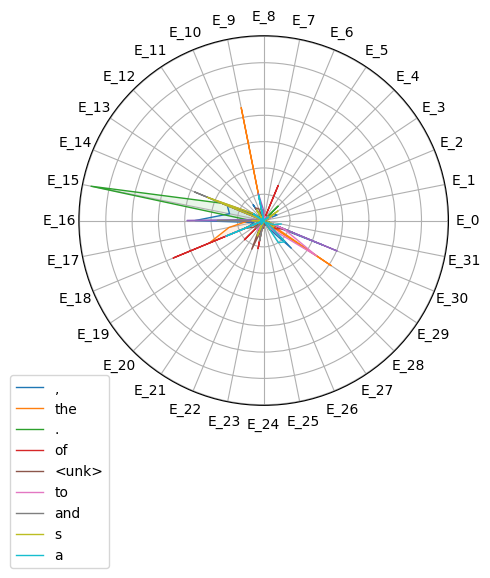

In [8]:
plot_polar(experts_by_inputs,all_input_ids,tokenizer)

In [9]:
tokens_rows = []
tokens_count = 10
expert_ids = [0,1,21,30,31]
for e in expert_ids:
    tokens = tokenizer.batch_decode([[c[0]] for c in experts_by_inputs[e].most_common(tokens_count)])    
    tokens_rows.append(tokens)
top_tokens = pd.DataFrame(tokens_rows,index=expert_ids,columns=[f"Token_{c}" for c in range(tokens_count)])
top_tokens.index.name = "Expert ID"
top_tokens

,Token_0,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9
Expert ID,,,,,,,,,,
0,<unk>,sk,si,IC,sha,ound,iatric,gg,bounce,JP
1,<unk>,olb,əmə,보장,сте,ਤੇ,ੋ,ੈ,казино,Μεγάλη
21,to,been,there,people,would,some,like,just,may,<unk>
30,,",",.,:,to,of,(,s,a,-
31,be,a,your,their,his,our,when,its,if,in
